In [33]:
%load_ext autoreload
%autoreload 2

import os, torch, click, numpy as np

import swyft
from utils import *
from plot import *

from tqdm import tqdm



DEVICE = 'cuda'


from torch import tensor

imkwargs = dict(extent=(-2.5, 2.5, -2.5, 2.5), origin='lower') #left, right, bottom, top

import matplotlib.colors
from IPython.display import HTML
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['axes.facecolor']='white'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
m = 1
nsub = 5
nsim = 25_000
nsim = 50_000

nmbins = 3

# nsub = 10
# nsim = 100_000
# nmbins = 5

lr = 1e-3
factor = 1e-1
patience = 5

system_name = "ngc4414"

In [3]:
# Set utilities
sim_name, sim_path = get_sim_path(m, nsub, nsim, system_name)
store = swyft.Store.load(path=sim_path)
print(f'Store has {len(store)} simulations.')

config = get_config(system_name, str(nsub), str(m))

prior, n_pars, lows, highs = get_prior(config)
L = config.kwargs["defs"]["nx"]
print(f'Image has L = {L}.')

# dataset = swyft.Dataset(nsim, prior, store)#, simhook = noise)

Store _M_m1_nsub5_nsim50000 exists!
Loading existing store.
Store has 49701 simulations.
Image has L = 40.


In [4]:
# Load network
mre_name, mre_path = get_mre_path(sim_name, nmbins, lr, factor, patience)
print(f'Loading {mre_name}!')

torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK

marginal_indices, _ = swyft.utils.get_corner_marginal_indices(n_pars)

network = get_custom_marginal_classifier(
    observation_transform = CustomObservationTransform('image', {'image': (L, L)}),
    marginal_indices = marginal_indices,
    L = L,
    nmbins = nmbins, 
    lows = lows,
    highs = highs,
    marginal_classifier = CustomMarginalClassifier,
)

mre = swyft.MarginalRatioEstimator.load(
    network=network,
    device=DEVICE,
    filename=mre_path,
)

torch.set_default_tensor_type(torch.FloatTensor)

Loading UNet_M_m1_nsub5_nsim50000_nmbins3_lr-3.0_fac-1.0_pat5.pt!


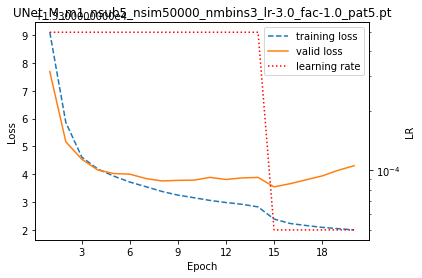

In [5]:
plot_losses(mre, title = mre_name)#, save_name = mre_name)

In [6]:
def get_coords(nmbins, L):
    grid = torch.linspace(lows[0], highs[0], L+1)[:-1]
    x, y = torch.meshgrid(grid, grid, indexing = 'xy')
    m = torch.logspace(lows[-1], highs[-1], 2*nmbins+1)
    m_centers, m_edges = m[1::2], m[0::2]
    ms = [torch.full((L*L,), m_i) for m_i in m_centers]

    coord_empty = torch.tensor((), device = DEVICE, dtype = torch.float).reshape(1, -1)
    
    coord_full = []
    for m in ms:
        coord = torch.transpose(torch.stack((x.flatten(), y.flatten(), m)), 0, 1).reshape(1, -1).to(DEVICE, dtype = torch.float)
        coord_full.append(coord)

    coords = [coord_empty] + coord_full
    return coords, coord_empty, coord_full, m_centers, m_edges 

def get_obs(store, i = -1):
    obs0_i = np.random.randint(0, len(store)) if i == -1 else i
#     print(f'i = {obs0_i}')
    
    obs0 = store[obs0_i][0]
    v0 = store[obs0_i][1]

    obs0['image'] = tensor(obs0['image']).unsqueeze(0).to(DEVICE, dtype = torch.float)
    v0 = tensor(v0).unsqueeze(0).to(DEVICE)
    
    return obs0, v0, obs0_i

coords, coord_empty, coord_full, m_centers, m_edges = get_coords(nmbins, L)

mbins = np.linspace(lows[2], highs[2], nmbins + 1)
title_mbins = [f'mass {mbins[i]} - {mbins[i+1]}' for i in range(nmbins)]
title_halos = [f'{j} {k}' for j in ['no halo', 'halo'] for k in title_mbins ]
titles = [f'{i} {j}' for i in ['target', 'ratio '] for j in title_halos ]


In [7]:
prior = nsub/(L*L)/nmbins
prior0 = 1 - prior
prior1 = prior
priors = np.repeat(np.array([prior0, prior1]), nmbins) 

print(f'prior no halo \t{prior0}\npario halo \t{prior1}')

prior no halo 	0.9989583333333333
pario halo 	0.0010416666666666667


In [8]:
def get_pred(obs0_i = -1):
    
    # Get observation and targets
    obs0, v0, obs0_i = get_obs(store, obs0_i)
    targets = mre.network.parameter_transform(v0).squeeze()

    # Get logratios
    logratios = np.zeros((nmbins*2, L, L))
    logratios[:nmbins] = mre.network(obs0, coord_empty).view(nmbins*2, L, L)[:nmbins]
    logratios[nmbins:] = torch.stack([
        mre.network(obs0, coord).view(nmbins*2, L, L)[i+nmbins] for i, coord in enumerate(coord_full)
    ])
        
    # Posterior 
    posts = np.exp(logratios) * (priors)[:, np.newaxis, np.newaxis]
    posts_sum = np.sum(posts.reshape(2, nmbins, L, L).transpose([1,0,2,3]), axis = 1)
    posts_sum = np.tile(posts_sum, (2,1,1))
    posts_norm = posts / posts_sum
    
    # Target coordinates
    x, y, m = v0.view(-1, 3).T.numpy()
    m_i = np.where(targets[nmbins:] == 1)[0]
    target_coords = np.array((m_i, x, y)).T
    target_coords_alt = np.array((m_i, y,x)).T
    
    scatter = np.array([np.array(np.where(targets[nmbins:] == 1))[i] for i in [2, 1, 0]])
    scatter_alt= np.array([np.array(np.where(targets[nmbins:] == 1))[i] for i in [1,2, 0]])
    
    return posts_norm[nmbins:], target_coords, target_coords_alt, scatter, scatter_alt, obs0_i, obs0, [x,y,m], posts, targets, obs0_i



## Final results

In [9]:
def find_nrows(l):
    if l > 1:
        a = np.array([(i, l/i, i+l/i) for i in range(1, l) if (l/i).is_integer()])
        i_min = np.argmin(a[:, -1], axis = 0)
        return int(a[i_min].min()) 
    else:
        return 1

32.55529064941407


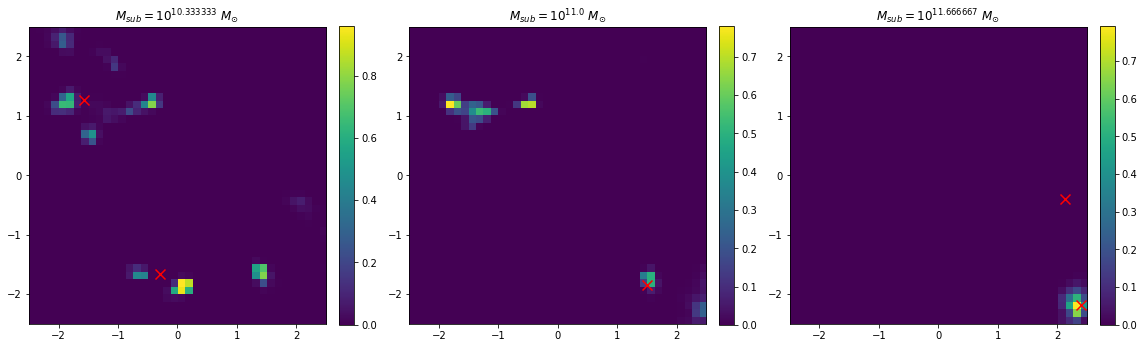

In [10]:
for _ in range(1):
#   30627
    post, target_coords, target_coords_alt, scatter, scatter_alt, obs0_i, obs0, [x,y,m], posts_all, targets, obs0_i = get_pred(-1)
    
    print(np.sum(post))
    
    nrows = find_nrows(len(post))
    titles = [rf'$M_{{sub}} = 10^{ {m} }\ M_{{\odot}}$' for m in np.log10(m_centers.numpy())]

    log = False
    plt_imshow(post, nrows, target_coords = target_coords, cbar = True, titles = titles, tl = True, ylog = log, **imkwargs)
#     plt_imshow(post, nrows, target_coords = target_coords_alt, cbar = True, titles = titles, tl = True, ylog = log, **imkwargs)


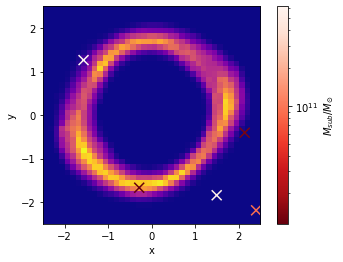

In [11]:
fig, ax = plt.subplots()

ax.imshow(obs0['image'].squeeze(), cmap = 'plasma', **imkwargs)
im = ax.scatter(x, y, marker = 'x', s = 100, c = m, cmap = 'Reds_r', norm=matplotlib.colors.LogNorm())

cbar = plt.colorbar(im, ax = ax)
cbar.ax.set_ylabel(r'$M_{sub}/M_{\odot}$')

plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Lava lamp

In [12]:
def normalize(d):
    d -= d.min()
    d /= d.max()
    return d

def cuboid_data(edges):
    # code taken from
    # http://stackoverflow.com/questions/30715083/python-plotting-a-wireframe-3d-cuboid?noredirect=1&lq=1
    # suppose axis direction: x: to left; y: to inside; z: to upper
    x1, x2, y1, y2, z1, z2 = edges
    x = [[x1, x2, x2, x1, x1],                # x coordinate of points in bottom surface
         [x1, x2, x2, x1, x1],                # x coordinate of points in upper surface
         [x1, x2, x2, x1, x1],                # x coordinate of points in outside surface
         [x1, x2, x2, x1, x1]]                # x coordinate of points in inside surface
    y = [[y1, y1, y2, y2, y1],                # y coordinate of points in bottom surface
         [y1, y1, y2, y2, y1],                # y coordinate of points in upper surface
         [y1, y1, y1, y1, y1],                # y coordinate of points in outside surface
         [y2, y2, y2, y2, y2]]                # y coordinate of points in inside surface
    z = [[z1, z1, z1, z1, z1],                # z coordinate of points in bottom surface
         [z2, z2, z2, z2, z2],                # z coordinate of points in upper surface
         [z1, z1, z2, z2, z1],                # z coordinate of points in outside surface
         [z1, z1, z2, z2, z1]]                # z coordinate of points in inside surface
    return np.array((x, y, z))

def plotCubeAt(edges, c="b", alpha=1, ax=None):
    # Plotting N cube elements at position pos
    if ax !=None:
        X, Y, Z = cuboid_data( edges )
        ax.plot_surface(X, Y, Z, color=c, rstride=1, cstride=1, alpha=alpha)

def plotMatrix(ax, x, y, z, threshold, data, cmap=plt.cm.viridis, cax=None, falpha=1):
    # plot a Matrix 
    norm = matplotlib.colors.Normalize(vmin=data.min(), vmax=data.max())
    colors = lambda i,j,k : matplotlib.cm.ScalarMappable(norm=norm,cmap = cmap).to_rgba(data[i,j,k]) 
    alphas = lambda i,j,k : normalize(data)[i,j,k] 
    
    for i, xi in enumerate(range(p.shape[0])):
        for j, yi in enumerate(range(p.shape[1])):
            for k, zi, in enumerate(range(p.shape[2])):
                if data[i,j,k] > threshold:
                    edges = (x[i], x[i+1], y[j], y[j+1], z[k], z[k+1])
                    plotCubeAt(edges, c=colors(i,j,k), alpha=alphas(i,j,k), ax=ax)


In [13]:
x_edges = np.linspace(-2.5, 2.5, L+1)
y_edges = np.linspace(-2.5, 2.5, L+1)
z_edges = np.log10(m_edges.numpy())
p = np.transpose(post, [1,2,0])

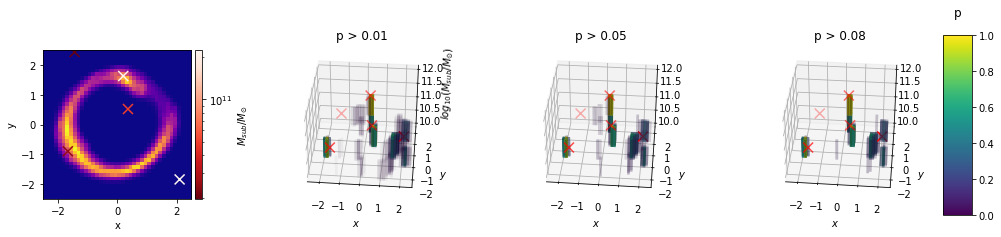

In [14]:
def lava_movie(obs0_i = -1, frames = 10, thresholds = [0.1, 0.5, 0.8]):
    post, _, _, scatter, scatter_alt, obs0_i, obs0, [x,y,m], _, targets, obs0_i = get_pred(obs0_i = obs0_i)
    

    fig = plt.figure(figsize = (20,5))
    
    ax = fig.add_subplot(1, len(thresholds)+2, 1)
    ax.imshow(obs0['image'].squeeze(), cmap = 'plasma', **imkwargs)
    im = ax.scatter(x, y, marker = 'x', s = 100, c = m, cmap = 'Reds_r', norm=matplotlib.colors.LogNorm())
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax = cax)
    cbar.ax.set_ylabel(r'$M_{sub}/M_{\odot}$')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    
    
    x_edges = np.linspace(-2.5, 2.5, L+1)
    y_edges = np.linspace(-2.5, 2.5, L+1)
    z_edges = np.log10(m_edges.numpy())
    p = np.transpose(post, [2,1,0])

    axs = ([])

    for i, threshold in enumerate(thresholds):
        ax = fig.add_subplot(1, len(thresholds)+2, i+2, projection='3d')
        plotMatrix(ax, x_edges, y_edges, z_edges, threshold, p)

        ax.scatter(x, y,np.log10(m), marker = 'x', color = 'red', s = 100)
        
        ax.set_xlim(-2.5, 2.5)
        ax.set_ylim(-2.5, 2.5)
        

        labelsize = 10
        ax.set_title(f'p > {threshold}')
        ax.set_xlabel(r'$x$', fontsize = labelsize)
        ax.set_ylabel(r'$y$', fontsize = labelsize)
        if i == 0: ax.set_zlabel(r'$log_{10}(M_{sub}/M_{\odot})$', fontsize = labelsize)

        axs.append(ax)
    
    ax.view_init(elev=90., azim=0.)



    ax = fig.add_axes([0.75, 0.25, 0.02, 0.5])
    norm = matplotlib.colors.Normalize(vmin=p.min(), vmax=p.max())
    cbar = matplotlib.colorbar.ColorbarBase(ax, cmap=plt.cm.viridis,
                                norm=norm,
                                orientation='vertical')  
    cbar.ax.set_title('p', pad = 19)

    fig.subplots_adjust(wspace=0.5)

    def animate(i):
        for ax in axs:
            ax.view_init(elev=35., azim=-90+5.+i)
        return fig,

    ani = animation.FuncAnimation(fig, animate, #init_func=init,
                                   frames=frames, interval=200, blit=True)    
    
    return ani, obs0_i, targets
    
    
# obs0_is = [obs0_i]
obs0_is = [-1]

for obs0_i in obs0_is:
    ani, obs0_i, targets = lava_movie(obs0_i = obs0_i, frames = 10, thresholds = [0.01, 0.05, 0.08])
#     ani.save(f'mp4s/{obs0_i}.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
#     ani.save(f'gifs/{obs0_i}.gif')
#     HTML(ani.to_html5_video())

we then derive the frequency with which t% highest density intervals contain the true value θd

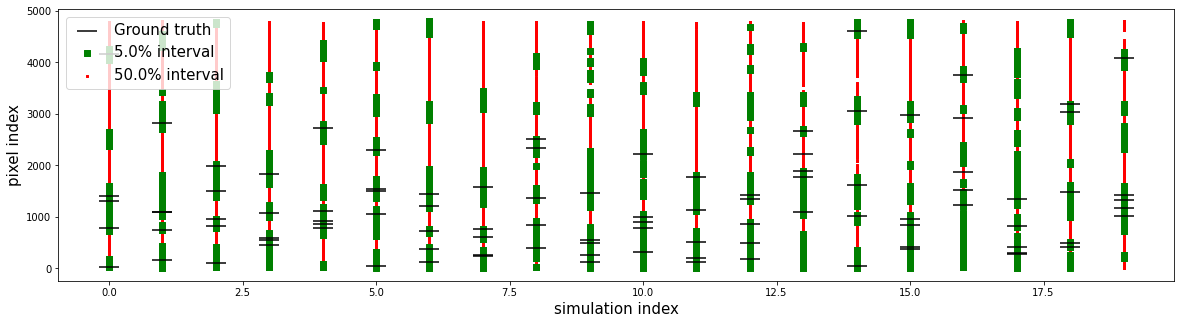

In [15]:
n_obs_samples = 20
indices = []
# percentages = np.array([0.6827, 0.9545])
percentages = np.array([0.05, 0.50])

s = 4

for ind in range(n_obs_samples):

    # ind = np.random.randint(n_obs_samples)
    post, target_coords, target_coords_alt, scatter, scatter_alt, obs0_i, obs0, [x,y,m], posts_all, targets, obs0_i = get_pred(ind)

    post_indices = np.argsort(post.flatten())[::-1] # get the sorted indics of the posterior
    true_indices = np.array(np.where(targets[nmbins:].flatten() == 1))[0] # get the indices of the true values

    indices.append((
        true_indices,
        post_indices[:int(np.round(len(post_indices)*percentages[0]))],
        post_indices[:int(np.round(len(post_indices)*percentages[1]))]
    ))

    
fig = plt.figure(figsize = (20, 5))
for i, index in enumerate(indices):
    scat2 = plt.scatter(np.repeat(i, len(index[2])), index[2], marker='s', c='r', s=1*s)
    scat1 = plt.scatter(np.repeat(i, len(index[1])), index[1], marker='s', c='g', s=10*s)
    scat0 = plt.scatter(np.repeat(i, len(index[0])), index[0], marker='_', c='black', s=100*s)
    

fontsize = 15
plt.ylabel('pixel index', fontsize = fontsize)
plt.xlabel('simulation index', fontsize = fontsize)
plt.legend([scat0, scat1, scat2], ['Ground truth', f'{percentages[0]*100}% interval', f'{percentages[1]*100}% interval'], fontsize = fontsize)
    
plt.show()

  6%|▌         | 6/100 [00:00<00:03, 28.56it/s]/scratch/ipykernel_22768/1828746643.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  target_coords = np.array((m_i, x, y)).T
/scratch/ipykernel_22768/1828746643.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  target_coords_alt = np.array((m_i, y,x)).T
100%|██████████| 100/100 [00:03<00:00, 28.00it/s]


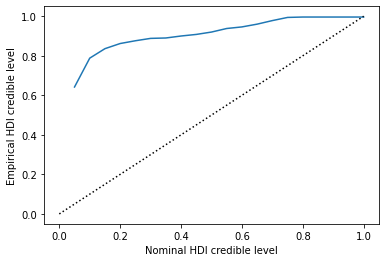

In [16]:
def mass(n_obs_samples, n_observations):

    nominal_mass = np.linspace(1 / n_observations, 1, n_observations)
    empirical_mass = np.zeros(len(nominal_mass))   
    emperical_masses = np.zeros((nmbins, len(nominal_mass)))
    
    for _ in tqdm(range(n_obs_samples)): # loop over number of observations we will take into account
        ind = np.random.randint(n_obs_samples)
#         post, targets = get_pred(ind) # get random posterior and target (true value) maps
        post, target_coords, target_coords_alt, scatter, scatter_alt, obs0_i, obs0, [x,y,m], posts_all, targets, obs0_i = get_pred(ind)
        
        post_indices = np.argsort(post.flatten())[::-1] # get the sorted indics of the posterior
        true_indices = np.array(np.where(targets[nmbins:].flatten() == 1))[0] # get the indices of the true values
        
        true_indices_2 = np.array(np.where(targets[nmbins:] == 1)).T # get the (x,y,M) index of the true values

        
        for i, percentage_index in enumerate(len(post_indices)*nominal_mass): # loop over x-axis (nominal_mass)
            post_indices_untill = post_indices[:int(np.round(percentage_index))]
            
            for true_index, true_index_2 in zip(true_indices, true_indices_2):
                if true_index in post_indices_untill:
                    empirical_mass[i] += 1
                    emperical_masses[true_index_2[0],i] += 1
#                     print(true_index_2[0])
#                     print(i)
    

    empirical_mass /= len(true_indices) # divide by number of true values
    empirical_mass /= n_obs_samples     # divide by number of observations we sampled
    
#     empirical_mass /= len(true_indices) # divide by number of true values
    emperical_masses /= n_obs_samples     # divide by number of observations we sampled
    
#     nominal_mass, empirical_mass = np.insert(nominal_mass, 0, 0), np.insert(empirical_mass, 0, 0) # prepend zeroes so our line starts at (0,0)
            
    return nominal_mass, empirical_mass, emperical_masses

def plot_mass(nominal_mass, empirical_mass):
    plt.plot(nominal_mass, empirical_mass)
    plt.plot([0, 1], [0, 1], "k:")
    plt.xlabel("Nominal HDI credible level")
    plt.ylabel("Empirical HDI credible level")
    plt.show()
    
nominal_mass, empirical_mass, emperical_masses = mass(100, 20)
plot_mass(nominal_mass, empirical_mass)

In [17]:
from pyrofit.lensing.distributions import get_default_shmf

In [18]:
shmf = get_default_shmf(z_lens = 0.5, log_range = (10., 12.))

In [19]:
x = torch.logspace(10, 12)
y = shmf.to_original(x)
# plt.plot(x, (1 - y)*h[0][0])

/scratch/ipykernel_22768/2316237700.py:1: UserWarning: Not providing a value for logspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  ../aten/src/ATen/native/RangeFactories.cpp:54.)
  x = torch.logspace(10, 12)


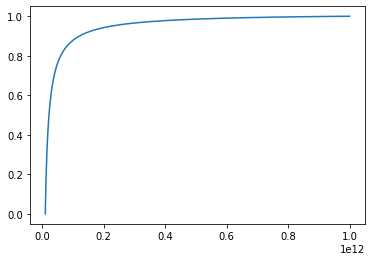

In [20]:
plt.plot(x, y)

In [21]:
import scipy.integrate as scint

In [22]:
scint.simps(y, x)

943850232783.6954

In [23]:
a, b = 10., 12.
shmf =  get_default_shmf(z_lens = 0.5, log_range = (a, b))
bins = np.logspace(a, b)

In [24]:
h

NameError: name 'h' is not defined

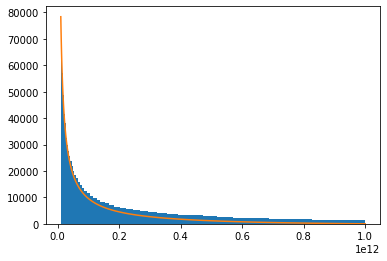

In [25]:
plot = shmf.sample((int(1e6),)).numpy()

h = plt.hist(plot, bins = bins)

x = torch.logspace(10, 12)
y = shmf.to_original(x)
plt.plot(x, (1 - y)*h[0][0])

plt.show()

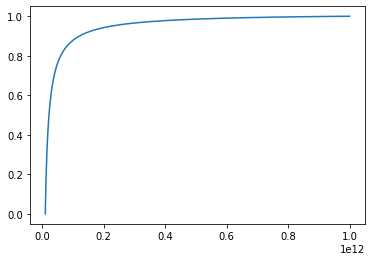

In [26]:
plt.plot(x, y)

In [ ]:
assert 1 == 2

In [ ]:
h[0].shape, h[1].shape

In [ ]:
scint.quad(func = f, a = 10., 12.)

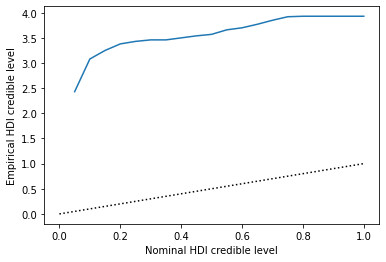

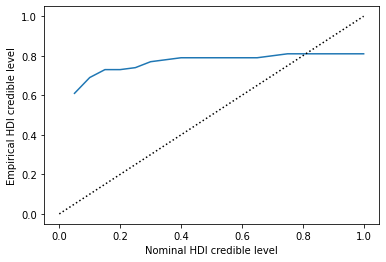

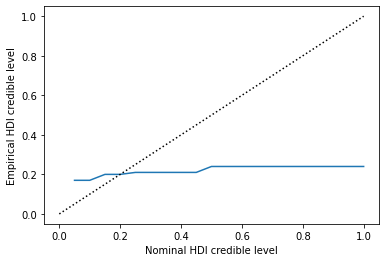

In [27]:
for m in emperical_masses:
    plot_mass(nominal_mass, m)
#     plt.plot(m)
#     plt.show()

In [ ]:
plt.plot(emperical_masses.T)

In [28]:
true_indices = np.array(np.where(targets[nmbins:].flatten() == 1))[0]
true_indices

array([1027, 1168, 1326, 1424, 4084])

In [29]:
true_indices_2 = np.array(np.where(targets[nmbins:] == 1)).T # get the indices of the true values
for i in true_indices_2:
    print(i)

[ 0 25 27]
[ 0 29  8]
[ 0 33  6]
[ 0 35 24]
[ 2 22  4]


x, marginalized over the other


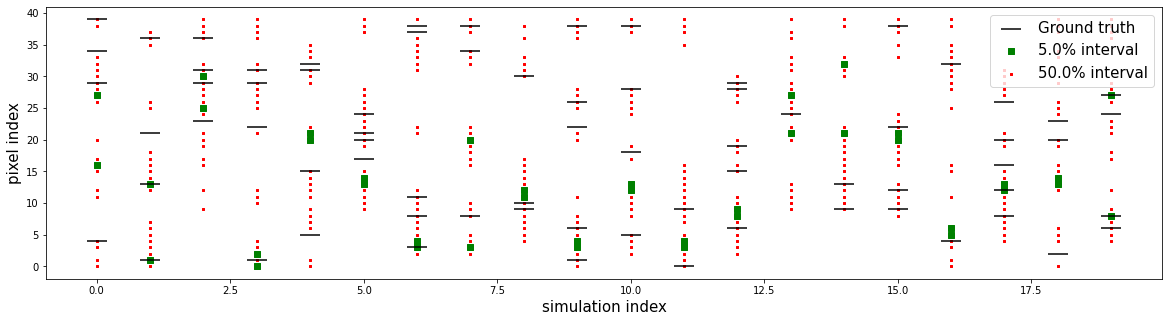

y, marginalized over the other


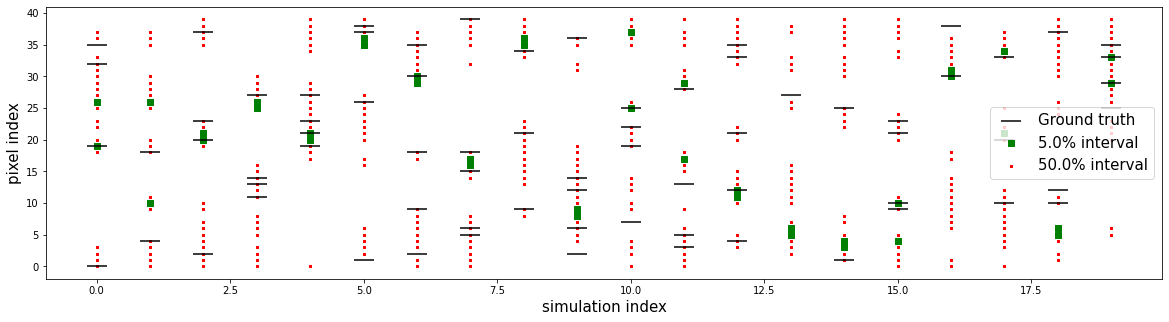

In [31]:
n_obs_samples = 20
indices = {'x':[], 'y':[]}

# percentages = np.array([0.6827, 0.9545])
percentages = np.array([0.05, 0.50])

s = 4

for ind in range(n_obs_samples):

    # ind = np.random.randint(n_obs_samples)
    post, target_coords, target_coords_alt, scatter, scatter_alt, obs0_i, obs0, [x,y,m], posts_all, targets, obs0_i = get_pred(ind)

    
    for axis, axis_i in zip(['x','y'], [0, 1]):
        marg = np.sum(post[0], axis = axis_i)
        post_indices = np.argsort(marg)[::-1]

        t_marg = np.sum(targets[nmbins:].numpy()[0], axis = axis_i)
        true_indices = np.where(t_marg == 1)[0]

        indices[axis].append((
            true_indices,
            post_indices[:int(np.round(len(post_indices)*percentages[0]))],
            post_indices[:int(np.round(len(post_indices)*percentages[1]))]
        ))
        
    
for axis, indices_axis in indices.items():
    print(f'{axis}, marginalized over the other')
    fig = plt.figure(figsize = (20, 5))
    for i, index in enumerate(indices_axis):
        scat2 = plt.scatter(np.repeat(i, len(index[2])), index[2], marker='s', c='r', s=1*s)
        scat1 = plt.scatter(np.repeat(i, len(index[1])), index[1], marker='s', c='g', s=10*s)
        scat0 = plt.scatter(np.repeat(i, len(index[0])), index[0], marker='_', c='black', s=100*s)


    fontsize = 15
    plt.ylabel('pixel index', fontsize = fontsize)
    plt.xlabel('simulation index', fontsize = fontsize)
    plt.legend([scat0, scat1, scat2], ['Ground truth', f'{percentages[0]*100}% interval', f'{percentages[1]*100}% interval'], fontsize = fontsize)

    plt.show()


 63%|██████▎   | 315/500 [00:11<00:07, 25.41it/s]/scratch/ipykernel_22768/1828746643.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  target_coords = np.array((m_i, x, y)).T
/scratch/ipykernel_22768/1828746643.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  target_coords_alt = np.array((m_i, y,x)).T
100%|██████████| 500/500 [00:18<00:00, 26.56it/s]


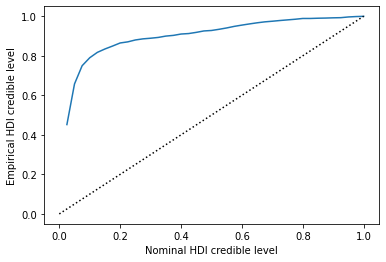

In [32]:
def mass(n_obs_samples, n_observations):

    nominal_mass = np.linspace(1 / n_observations, 1, n_observations)
    empirical_mass = np.zeros(len(nominal_mass))   

    for _ in tqdm(range(n_obs_samples)): # loop over number of observations we will take into account
        ind = np.random.randint(n_obs_samples)
#         post, targets = get_pred(ind) # get random posterior and target (true value) maps
        post, target_coords, target_coords_alt, scatter, scatter_alt, obs0_i, obs0, [x,y,m], posts_all, targets, obs0_i = get_pred(ind)
        
        
        for axis, axis_i in zip(['x','y'], [0, 1]):
            marg = np.sum(post[0], axis = axis_i)
            post_indices = np.argsort(marg)[::-1]

            t_marg = np.sum(targets[nmbins:].numpy()[0], axis = axis_i)
            true_indices = np.where(t_marg == 1)[0]

            indices[axis].append((
                true_indices,
                post_indices[:int(np.round(len(post_indices)*percentages[0]))],
                post_indices[:int(np.round(len(post_indices)*percentages[1]))]
            ))
        
        
        post_indices = np.argsort(post.flatten())[::-1] # get the sorted indics of the posterior
        true_indices = np.array(np.where(targets[nmbins:].flatten() == 1))[0] # get the indices of the true values
        
        for i, percentage_index in enumerate(len(post_indices)*nominal_mass): # loop over x-axis (nominal_mass)
            post_indices_untill = post_indices[:int(np.round(percentage_index))]
            
            for true_index in true_indices:
                if true_index in post_indices_untill:
                    empirical_mass[i] += 1
    

    empirical_mass /= len(true_indices) # divide by number of true values
    empirical_mass /= n_obs_samples     # divide by number of observations we sampled
    
#     nominal_mass, empirical_mass = np.insert(nominal_mass, 0, 0), np.insert(empirical_mass, 0, 0) # prepend zeroes so our line starts at (0,0)
            
    return nominal_mass, empirical_mass

def plot_mass(nominal_mass, empirical_mass):
    plt.plot(nominal_mass, empirical_mass)
    plt.plot([0, 1], [0, 1], "k:")
    plt.xlabel("Nominal HDI credible level")
    plt.ylabel("Empirical HDI credible level")
    plt.show()
    
nominal_mass, empirical_mass = mass(500, 40)
plot_mass(nominal_mass, empirical_mass)

In [ ]:
plt_imshow(np.concatenate((post, t)), cbar = True, titles = ['prediction', 'target'])